<a href="https://colab.research.google.com/github/lukegriffiths/mohr-coulomb-failure/blob/main/mohr_couloumb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an example of calculating the best-fit Mohr-Coulumb failure
criteria from the horizontal and vertical effective stresses.


In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

def return_p_q(sig1, sig3):
    return (sig1+sig3)/2, (sig1-sig3)/2


def shortest_distance(x1, y1, a, b, c):
    """
    Gives distance between point (x1, y1) and line a*x + b*y + c = 0
    """
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
    return d


def diff_between_dist_to_MCline_and_q(sig1, sig3, cohesion, mu):
    """
    Calculates the difference between (1) the shortest distance from the center of 
    the circle (p,0) to the failure criteria line, and (2) the radius of the circle

    When this is zero, the failure criteria line is tangent to the circle.
    """
    p, q = return_p_q(sig1, sig3)
    # distance between (p,0) and y = mu*x + cohesion
    dist_MC_line = shortest_distance(p, 0, mu, -1, cohesion)

    # calcualte the square of the difference with q (the radius)
    diff = (dist_MC_line-q)**2

    print('Distance to MC line: {}, Radius: {}, Diff {}'.format(
        dist_MC_line, q, diff))

    return diff


def fit_func(X, s1, s3):
    """
    Returns a cost function which is the sum of the differences between the 
    circle and the failure criteria line for all circles
    """
    cohesion, mu = X[0], X[1]
    print('Cohesion: {} MPa, and Friction angle: {}'.format(
        cohesion, np.arctan(mu)/np.pi*180))
    diff_sum = 0

    # the function to minimise takes in to account all the distances between
    # the MC line and the radius of each circle.
    for sig1, sig3 in zip(s1, s3):
        diff_sum += diff_between_dist_to_MCline_and_q(sig1, sig3, cohesion, mu)
    return diff_sum


def calculate_friction_angle_from_coefficient(friction_coefficient):
    """
    Calculate the friction angle in degrees
    """
    return np.arctan(friction_coefficient)/np.pi*180


def calculate_cohesion_friction(sig1_set, sig3_set, cohesion_ini, mu_ini,
                                bnds=((0.0, 100), (0, 10))):
    
    # imports
    import functools
    from scipy.optimize import minimize

    # create cost function considering the input stresses
    G = functools.partial(fit_func, s1=sig1_set, s3=sig3_set)

    # initial guess
    p0_initial_assumption = [cohesion_ini, mu_ini]

    # find minimum of cost function
    res = minimize(G, p0_initial_assumption, bounds=bnds)

    cohesion = res.x[0]
    friction_coefficient = res.x[1]

    friction_angle = calculate_friction_angle_from_coefficient(
        friction_coefficient)

    print('\nBest fitted MC parameters: Cohesion: {} MPa, and Friction angle: {}'.format(
        cohesion, friction_angle))

    return cohesion, friction_coefficient


# plot the figure of the mohr circles and failure criteria

def plot_mohr_circles(p, q, cohesion=None, friction_coefficient=None):
    """
    makes plot of p, q, their corresponding mohr circles, and the Mohr-Coulomb 
    failure criteria if available
    """
    import matplotlib.pyplot as plt

    f, ax = plt.subplots(figsize=(15, 8))
    ax.plot(p, q, 'o')
    ax.set_xlabel('p, (sig_v + sig_r)/2 ')
    ax.set_ylabel('q, sig_v - sig_r)/2')
    for a, b in zip(p, q):
        circle = plt.Circle((a, 0), b, color='k', fill=False)
        ax.add_artist(circle)
    if cohesion is not None and friction_coefficient is not None:
        x = np.insert(p, 0, 0) # so the line passes through the y-axis
        ax.plot(x, x*friction_coefficient + cohesion)
    plt.axis('scaled')
    ax.set_xlim(0, max(p)+1)
    ax.set_ylim(0, max(q)+1)
    plt.tight_layout()
    plt.show()
    return f


Input parameters for the calculation:
1.   The stress conditions at peak stress from the laboratory tests
2.   The initial guesses for guess of cohesion and friction coefficient.

Try running the code with different values of sig1_set and sig3_set

Cohesion: 5.0 MPa, and Friction angle: 30.963756532073525
Distance to MC line: 6.795631436271913, Radius: 1.875, Diff 24.21261373162739
Distance to MC line: 8.917926427410459, Radius: 3.0, Diff 35.021853200243115
Distance to MC line: 10.3971017242646, Radius: 3.875, Diff 42.53781090165526
Distance to MC line: 11.683341112833416, Radius: 4.375, Diff 53.41184982153117
Cohesion: 5.00000001 MPa, and Friction angle: 30.963756532073525
Distance to MC line: 6.795631444846842, Radius: 1.875, Diff 24.212613816015523
Distance to MC line: 8.91792643598539, Radius: 3.0, Diff 35.02185330173474
Distance to MC line: 10.397101732839529, Radius: 3.875, Diff 42.53781101350838
Distance to MC line: 11.683341121408345, Radius: 4.375, Diff 53.41184994686819
Cohesion: 5.0 MPa, and Friction angle: 30.96375695336602
Distance to MC line: 6.795631448093966, Radius: 1.875, Diff 24.21261384797132
Distance to MC line: 8.91792646524103, Radius: 3.0, Diff 35.02185364800018
Distance to MC line: 10.397101780222316, Rad

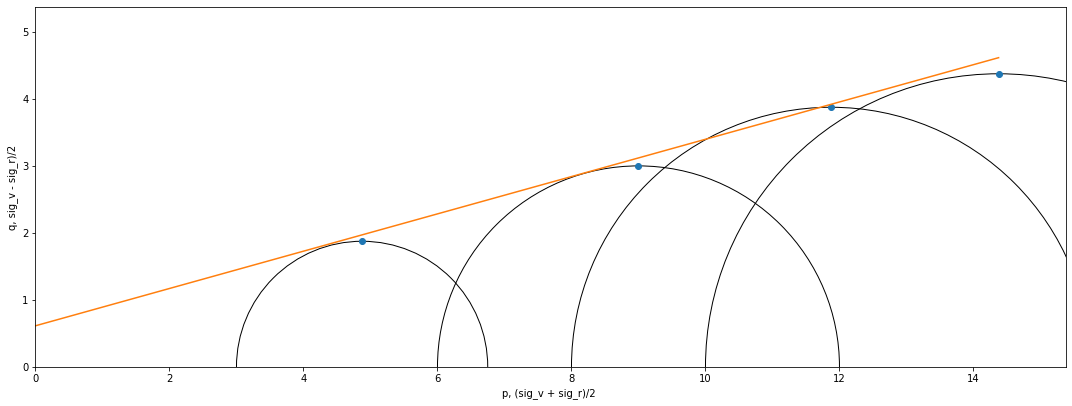

In [2]:
#%% Required input

# Stresses at failure/fault activation

# Vertical effective stress [MPa]
sig1_set = np.array([4.5, 8, 10.5, 12.5])*1.5  # perturbed friction coefficient

# Horizontal effective stress [MPa]
sig3_set = np.array([3, 6, 8, 10]) 

# Initial guess of cohesion and friction coefficient (for example, 
# calculated using the 45 degree fault angle assumption)
cohesion_ini = 5 # cohesion [MPa]
mu_ini = 0.6 # friction coefficient [-]

# calculate cohesion and friction angle
cohesion, friction_coefficient = calculate_cohesion_friction(
    sig1_set, sig3_set, cohesion_ini, mu_ini)

# calculate the angle (degrees) from the friction coefficient
friction_angle = calculate_friction_angle_from_coefficient(friction_coefficient)

# calculate p and q to make (P,Q plot)
p, q = return_p_q(np.array(sig1_set), np.array(sig3_set))

# plot the mohr circles
f = plot_mohr_circles(p, q, cohesion=cohesion,
                      friction_coefficient=friction_coefficient)
plt.show()